# What is Uplift Modeling? 

Many companies can predict customer behavior, such as churn. But the outflow itself does not give us much, because the main task for a business is to maximize profits. To give an example, we have a client who has not interacted with a product for a long time, and our model predicts that he will leave soon.  We decide to do our best and keep the client in the company, but in fact we only infuriated him when we sent another spam email. And even if the client didn't want to leave, he left. Therefore, our task turns from who will leave to the task of finding users who want to leave, but also on whom our letter will have a positive effect. And don't send emails to someone who doesn't need to.

So,  uplift modeling is equivalent to estimating a CATE (Conditional Average Treatment Effect)

Estimating uplift is inherently both a causal inference and a machine learning problem. It is a causal inference problem because we seek to quantify the difference between two mutually exclusive potential outcomes for the same individual (e.g., person 𝑖 receives the promotional offer versus does not receive it). Since these counterfactual outcomes cannot be observed simultaneously, uplift modeling relies heavily on randomized controlled experiments, where individuals are randomly assigned to treatment and control groups. At the same time, uplift is a machine learning problem because one must fit predictive models and evaluate which approach provides the most accurate uplift estimates. This involves careful model selection, cross-validation procedures, and often extensive feature engineering.


We can divide our users by 4 groups:

1. The group of users will complete the action anyway with or without treatment - the most loyalty users
2. The group of users will complete the action only after treatment -> **our target group**
3. The group of users performs without treatment, but may stop it after treatment
4. The group of users will not respond anaway with our without treatment


## Approaches to Uplift Modeling

Early work on uplift modeling proposed three main strategies, [can read here](https://proceedings.mlr.press/v67/gutierrez17a/gutierrez17a.pdf_clients_clients_clients_clients)

- Two-Model Approach: fit separate models for treated and control groups, then take their difference.
- Class Transformation: redefine the target variable to capture uplift and train a single classifier.
- Direct Uplift Models: optimize the model directly for uplift, e.g., using uplift decision trees.

While these methods laid the groundwork, more recent developments in causal machine learning reframed the problem in terms of estimating CATE

- S-learner: a single model including treatment as a feature, with uplift computed as the difference in predictions when toggling treatment.
- T-learner: essentially the Two-Model approach, with separate models for treated and control.
- X-learner and R-learner: refinements that improve efficiency by constructing pseudo-outcomes or using orthogonalization techniques.

Together, these modern learners bridge machine learning with causal inference, offering more robust tools for estimating individualized treatment effects.




To obtain a training sample for uplift modeling, it is necessary to conduct an experiment.:

Randomly split a representative part of the customer base into target and control groups;
Launch a pilot marketing campaign for the target group.

The only difference between the experiment and the future campaign should be the fact that in the first case, for interaction, you

This means that if we predict the value, there will be nothing to compare it with.

# libs

In [ ]:
import pandas as pd
import numpy as np
from datetime import timedelta

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

from scipy.stats import chisquare
from statsmodels.stats.proportion import proportions_ztest

from sklearn.model_selection import train_test_split


from sklift.models import SoloModel, TwoModels, ClassTransformation
from sklift.metrics import (
    uplift_at_k,
    uplift_auc_score,
    qini_auc_score,
    uplift_by_percentile
)
from sklift.viz import plot_uplift_preds

from catboost import CatBoostClassifier


# Data

In [25]:
purchases = pd.read_csv('data/purchases.csv')
product = pd.read_csv('data/products.csv')
clients = pd.read_csv('data/clients.csv')
uplift_test = pd.read_csv('data/uplift_test.csv')
uplift_train = pd.read_csv('data/uplift_train.csv')

# Func

In [ ]:
def plot_numeric_histograms(
    df, bins=30, figsize=(14, 4), n_cols=3, palette="muted", kde=False
):

    numeric_df = df.select_dtypes(include=np.number)
    num_features = numeric_df.shape[1]


    num_rows = (num_features + n_cols - 1) // n_cols
    fig, axes = plt.subplots(num_rows, n_cols, figsize=(figsize[0], figsize[1] * num_rows))
    fig.suptitle("Distribution of numerical features", fontsize=16, weight="bold")

    axes = np.atleast_1d(axes).ravel()


    for i, col in enumerate(numeric_df.columns):
        ax = axes[i]
        sns.histplot(numeric_df[col].dropna(), bins=bins, kde=kde, ax=ax, color=sns.color_palette(palette)[0])
        ax.set_title(col, fontsize=12, weight="semibold")
        ax.set_xlabel("")
        ax.set_ylabel("cnt")

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def summarize_client_purchases(purchases, limits=(500, 750, 1000)):
    summary = []

    for client, data in purchases.groupby('client_id'):
        stats = {'client_id': client}
        tx_sums = data.groupby('transaction_id')['purchase_sum'].sum()

        for limit in limits:
            above_limit = tx_sums[tx_sums > limit]
            stats[f'count_over_{limit}'] = len(above_limit)
            stats[f'total_over_{limit}'] = above_limit.sum()

        summary.append(stats)

    return pd.DataFrame(summary)

def compute_client_growth(
    purchases,
    period=3,
    unit="months",  # "months" or "days"
    date_col="transaction_datetime",
    client_col="client_id",
    amount_col="purchase_sum",
    return_pct=True  # if False -> absolute diff
):
    df = purchases[[client_col, date_col, amount_col]].copy()
    df[date_col] = pd.to_datetime(df[date_col])

    end_date = df[date_col].max()

    if unit == "months":
        offset = pd.DateOffset(months=period)
    elif unit == "days":
        offset = timedelta(days=period)
    else:
        raise ValueError("unit must be 'months' or 'days'")

    recent_start = end_date - offset
    previous_start = recent_start - offset

    out = []
    for client, g in df.groupby(client_col):
        recent = g[(g[date_col] >= recent_start) & (g[date_col] < end_date)]
        previous = g[(g[date_col] >= previous_start) & (g[date_col] < recent_start)]

        recent_sum = recent[amount_col].sum()
        previous_sum = previous[amount_col].sum()

        if return_pct:
            growth = ((recent_sum - previous_sum) / previous_sum * 100) if previous_sum > 0 else None
        else:
            growth = recent_sum - previous_sum

        out.append({
            client_col: client,
            "recent_sum": recent_sum,
            "previous_sum": previous_sum,
            "growth_{}{}".format(period, "m" if unit=="months" else "d"): growth
        })

    return pd.DataFrame(out)

# EDA

## purchases

- client_id - The client's ID, the foreign key to clients and uplift_train
- transaction_id - Purchase ID
- transaction_datetime - the date and time of the transaction.
- regular_points_received - The number of regular bonus points awarded to the customer for this purchase
- express_points_received - The number of express bonus points awarded to the customer (as part of the promotion, for example)
- regular_points_spent - The number of regular bonus points that the customer debited as part of this purchase
- express_points_spent - The number of express bonus points that the customer debited as part of this purchase
- purchase_sum - The total purchase amount
- store_id is the ID of the store where the purchase was made.
- product_id - The ID of the product purchased as part of the purchase
- product_quantity - The number of units of the product purchased as part of this purchase
- trn_sum_from_iss - Bonuses accrued on this purchase and immediately used for payment
- trn_sum_from_red - Bonuses that the client accumulated earlier and spent for this transaction

In [ ]:
purchases.shape

In [ ]:
purchases.isna().sum()

In [ ]:
purchases.info()

let's drop 'trn_sum_from_red', it's too many nan values, we can't replace them 

In [ ]:
purchases.drop(columns='trn_sum_from_red',inplace=True)

In [ ]:
purchases.head()

In [ ]:
purchases[['store_id','product_id','client_id','transaction_id']].nunique()

In [ ]:
purchases.product_id.nunique()

In [ ]:
purchases.client_id.nunique()

In [ ]:
purchases.describe()

In [ ]:
plot_numeric_histograms(purchases)

In [ ]:
purchases['transaction_datetime'] = pd.to_datetime(purchases['transaction_datetime'])

## product 

- product_id - the product ID
- level_1 - the top level of the category (Food)
- level_2 - the top-level subcategory (Dairy products)
- level_3 - a more detailed category (Yoghurts)
- level_4 - the most detailed category (Light yogurt)
- segment_id -  the identifier of the product segment. This can be a grouping of products by target audience or purpose (Premium goods, children's goods)
- brand_id - the product brand identifier
- vendor_id - ID of the order supplier
- netto - the weight or volume of the product
- is_own_trademark - a binary attribute (0/1) indicating whether the product is the company's own brand 
- is_alcohol -  a binary attribute (0/1) 

In [ ]:
product.shape

In [ ]:
product.info()

In [ ]:
product.isna().sum()

In [ ]:
# replacing null with the most frequent values
def most_frequent_value(col):
    if col.isna().all():
        return col 
    return col.fillna(col.mode()[0])

In [ ]:
product = product.apply(most_frequent_value, axis=0)

In [ ]:
print(product.isna().sum())

In [ ]:
product.head()

In [ ]:
product[['product_id','level_1','level_2','level_3','level_4','segment_id','brand_id','vendor_id','is_own_trademark','is_alcohol']].nunique()

In [ ]:
product.describe()

In [ ]:
plot_numeric_histograms(product[['netto']])

We see that there are a few products with a lot of weight, but we cannot prove that this is a mistake. since we don't have any product descriptions. Logically, let's assume this, and leave the values

## clients 

- first_issue_date - the datetime when the customer was first registered in the system or received his loyalty card
- first_redeem_date - the datetime when the customer first made a purchase or used their loyalty card

In [ ]:
clients.shape

In [ ]:
clients.info()

In [ ]:
clients.isna().sum()

In [ ]:
# share null values 
35469/400162*100

In [ ]:
clients.describe()

In [ ]:
clients.head(5)

In [ ]:
clients.groupby('gender').client_id.nunique()

In [ ]:
clients['first_issue_date'] = pd.to_datetime(clients['first_issue_date'])
clients['first_redeem_date'] = pd.to_datetime(clients['first_redeem_date'])

In [ ]:
clients.nunique()

In [ ]:
plot_numeric_histograms(clients)

- have clients with negative age -> replace by median value
- 9% null values in 'first_redeem_date' column -> let's see more details

In [ ]:
# 1 - fix age 
median_age=clients[(clients['age']>0)&(clients['age']<=100)]['age'].median()
clients['age']=clients['age'].apply(lambda x: median_age if x<=0 or x>100 else x)

In [ ]:
plot_numeric_histograms(clients)

#2 issue - why do we have 9% null values in 'first_redeem_date' column? Did these customers do purchases? if they did not have time to make a purchase, then our notification can help activate them - it is inappropriate to delete them.

In [ ]:
clients_without_reedem=clients[clients['first_redeem_date'].isna()]\
    .merge(purchases,on='client_id')
clients_without_reedem.head()

In [ ]:
clients[clients['first_redeem_date'].isna()].client_id.nunique()

In [ ]:
# all clients without activation made purcheses -> so,it seems it's a mistake, let's fill nulls
clients_without_reedem.client_id.nunique()

In [ ]:
# customers who first registered the card and then made purchases
clients_without_reedem[clients_without_reedem['first_issue_date']>=clients_without_reedem['transaction_datetime']].client_id.nunique()

In [ ]:
# customers who first made purchases then registered the card 
clients_without_reedem[clients_without_reedem['first_issue_date']<clients_without_reedem['transaction_datetime']].client_id.nunique()

We take customers with a redeem date, calculate the average number of days between the date of the first issue and the date of the redeem date, and fill in the empty fields.

In [ ]:
clients_with_reedem=clients[~clients['first_redeem_date'].isna()]

In [ ]:
clients_with_reedem['date_diff_redeem_issue']=(clients_with_reedem['first_redeem_date']-clients_with_reedem['first_issue_date']).dt.days

In [ ]:
clients_with_reedem.date_diff_redeem_issue.mean()

In [ ]:
clients_with_reedem.groupby('gender').date_diff_redeem_issue.mean()

In [ ]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=clients_with_reedem, x="gender", y="date_diff_redeem_issue")
plt.show()

fill in the gaps with an average based on gender. Men are not in such a hurry to activate the card

In [ ]:
mean_by_gender = clients_with_reedem.groupby('gender')['date_diff_redeem_issue'].mean()
global_mean = clients_with_reedem['date_diff_redeem_issue'].mean()

In [ ]:
clients['date_diff_redeem_issue']=(clients['first_redeem_date']-clients['first_issue_date']).dt.days

clients['date_diff_redeem_issue'] = (clients['date_diff_redeem_issue']\
    .fillna(clients['gender'].map(mean_by_gender).fillna(global_mean))
    .round().astype('Int64')
)

In [ ]:
clients['first_redeem_date'] = clients['first_redeem_date'].fillna(
    pd.to_datetime(clients['first_issue_date']) +
    pd.to_timedelta(clients['date_diff_redeem_issue'], unit='D')
)

In [ ]:
clients.info()

## uplift train

To understand which users are affected by notifications and which are not, they do an A/B test experiment.  This data is stored in the uplift_train table.

In [26]:
uplift_train.head()

,client_id,treatment_flg,target
0,000012768d,0,1
1,000036f903,1,1
2,00010925a5,1,1
3,0001f552b0,1,1
4,00020e7b18,1,1


step 1: that the groups in the A/B test (treatment_flg = 0/1) are evenly distributed, meaning we don't have a bias in the number of users. Even with significance level = 0.1 (0.1<0.863) our system is correct

In [27]:
obs = uplift_train['treatment_flg'].value_counts().sort_index().values
exp = [len(uplift_train) / 2] * 2
chi2, p = chisquare(f_obs=obs, f_exp=exp)
print("Chi2 statistic:", chi2)
print("p-value:", p)
print("Observed:", obs)
print("Expected:", exp)

Chi2 statistic: 0.029639220352031353
p-value: 0.8633113903439603
Observed: [100058  99981]
Expected: [100019.5, 100019.5]


In [28]:
uplift_train.groupby(['treatment_flg','target']).client_id.nunique()

treatment_flg  target
0              0         39695
               1         60363
1              0         36342
               1         63639
Name: client_id, dtype: int64

In [29]:
customers_ab = [100058, 99981]
successes = [60363, 63639]

In [33]:
print(f'conversion control:{round(successes[0]/customers_ab[0],3)}')
print(f'conversion treatment:{round(successes[1]/customers_ab[1],3)}')

conversion control:0.603
conversion treatment:0.637


In [38]:
uplift = round((successes[1]/customers_ab[1] - successes[0]/customers_ab[0])*100,3)
print(f'Treatment increased the likelihood of a targeted action on {uplift}%')

Treatment increased the likelihood of a targeted action on 3.323%


In [31]:
z, pval = proportions_ztest(successes, customers_ab, alternative='two-sided')
print(z, pval)

-15.309339918886566 6.623268877019162e-53


- The A/B test says that the effect exists as a whole.
- The Uplift model should tell you who exactly has it the most.

In [39]:
uplift_test.shape

(200123, 1)

# Features Engineering

In [ ]:
df_clients = clients.copy() 

In [ ]:
df_clients['first_issue_year'] = df_clients['first_issue_date'].dt.year
df_clients['first_issue_month'] = df_clients['first_issue_date'].dt.month
df_clients['first_issue_day'] = df_clients['first_issue_date'].dt.day
df_clients['first_issue_hour'] = df_clients['first_issue_date'].dt.hour
df_clients['first_issue_date_weekday'] = df_clients['first_issue_date'].dt.weekday

df_clients['first_redeem_year'] = df_clients['first_redeem_date'].dt.year
df_clients['first_redeem_month'] = df_clients['first_redeem_date'].dt.month
df_clients['first_redeem_day'] = df_clients['first_redeem_date'].dt.day
df_clients['first_redeem_hour'] = df_clients['first_redeem_date'].dt.hour
df_clients['first_redeem_date_weekday'] = df_clients['first_redeem_date'].dt.weekday

df_clients['redeem_issue_date_diff'] = (df_clients['first_redeem_date'] - df_clients['first_issue_date']).dt.days


In [ ]:
df_clients['age_group'] = pd.cut(
    df_clients['age'], bins=[0, 30, 50, 100], labels=[0, 1, 2]
)
gender_map = {'M': 0, 'F': 1, 'unknown': 2}
df_clients['gender_clean'] = df_clients['gender'].replace({'U': 'unknown'}).map(gender_map).astype(int)
del df_clients['gender']

In [ ]:
df_clients.head()

In [ ]:
purchases_total=purchases.merge(product, how='left', on='product_id')

In [ ]:
purchases_total.head()

In [ ]:
# Aggregates by client
grp = purchases_total.groupby('client_id')

# Shares by level_1...level_4 (uniq level / count purchases) and the most frequent id by level_i
shares = {}
for lvl in ['level_1', 'level_2', 'level_3', 'level_4']:
    shares[f'share_{lvl}'] = grp[lvl].apply(lambda x: x.nunique() / len(x))
    shares[f'most_frequent_{lvl}'] = grp[lvl].agg(lambda x: x.mode()[0])  
shares = pd.DataFrame(shares)

In [ ]:
# Share of purchases of own brands
shares['share_own_trademark'] = grp['is_own_trademark'].mean()
shares['sum_own_trademark'] = grp.apply(lambda x: x.loc[x['is_own_trademark'] == 1, 'purchase_sum'].sum())
shares['share_sum_own_trademark'] = grp.apply(lambda x: x.loc[x['is_own_trademark'] == 1, 'purchase_sum'].sum()/ x['purchase_sum'].sum())

In [ ]:
# The share of alcohol in the total bill
shares['share_is_alcohol'] = grp['is_alcohol'].mean()
shares['sum_is_alcohol'] = grp.apply(lambda x: x.loc[x['is_alcohol'] == 1, 'purchase_sum'].sum())
shares['share_sum_alcohol'] = grp.apply(lambda x: x.loc[x['is_alcohol'] == 1, 'purchase_sum'].sum() / (x['purchase_sum'].sum()))

In [ ]:
# Share of payments in points
shares['share_paid_with_points'] = grp.apply(
    lambda x: x['trn_sum_from_iss'].sum() / (x['purchase_sum'].sum()))
# Intensity of the use of points (spent/ received)
shares['points_intensity'] = grp.apply(
    lambda x: (x['regular_points_spent'].sum() + x['express_points_spent'].sum()) /
              (x['regular_points_received'].sum() + x['express_points_received'].sum()))

In [ ]:
# Different brands
shares['share_brands'] = grp.apply(lambda x : x['brand_id'].nunique()/len(x))
shares['most_frequent_brand'] = grp.apply(lambda x : x['brand_id'].mode()[0])

In [ ]:
#  Different segments
shares['share_segments'] = grp.apply(lambda x : x['segment_id'].nunique()/len(x))
shares['most_frequent_segment'] = grp.apply(lambda x : x['segment_id'].mode()[0])

In [ ]:
#  Different vendor
shares['share_vendors'] = grp.apply(lambda x : x['vendor_id'].nunique()/len(x))
shares['most_frequent_vendor'] = grp.apply(lambda x : x['vendor_id'].mode()[0])

In [ ]:
# Different product
shares['share_products'] = grp.apply(lambda x : x['product_id'].nunique()/len(x))
shares['most_frequent_product'] = grp.apply(lambda x : x['product_id'].mode()[0])

In [ ]:
# Total sum per purchase 
total_sum_per_purchase=purchases_total.groupby(['client_id','transaction_id'])['purchase_sum'].sum().reset_index()

agg_stats = (
    total_sum_per_purchase
    .groupby("client_id")["purchase_sum"]
    .agg(purchase_sum_max="max", purchase_sum_mean="mean")
    .reset_index()
)

shares = agg_stats.merge(shares, on="client_id", how="left")

In [ ]:
#  Total quantity per purchase 
total_quantity_per_purchase=purchases_total.groupby(['client_id','transaction_id'])['purchase_sum'].count().reset_index()

agg_stats = (
    total_quantity_per_purchase
    .groupby("client_id")["purchase_sum"]
    .agg(purchase_qua_max="max", purchase_qua_mean="mean")
    .reset_index()
)

shares = agg_stats.merge(shares, on="client_id", how="left")

In [ ]:
#  Total netto per purchase 
total_netto_per_purchase=purchases_total.groupby(['client_id','transaction_id'])['netto'].sum().reset_index()

agg_stats = (
    total_netto_per_purchase
    .groupby("client_id")["netto"]
    .agg(purchase_netto_max="max", purchase_netto_mean="mean")
    .reset_index()
)

shares = agg_stats.merge(shares, on="client_id", how="left")

In [ ]:
# Weight statistics 
weights = (
    grp.agg(
        avg_weight=('netto', 'mean'),
        min_weight=('netto', 'min'),
        max_weight=('netto', 'max')
    )
    .reset_index()
)

shares= shares.merge(weights, on='client_id')

In [ ]:
# Average check per kg and payment for purchases with points

purchases_total["txn_with_points"] = (purchases_total["trn_sum_from_iss"] > 0).astype(int)

agg = (
    purchases_total.groupby("client_id")
    .agg(
        sum_purchase=("purchase_sum", "sum"),
        sum_netto=("netto", "sum"),
        share_txn_with_points=("txn_with_points", "mean"),
    )
    .reset_index()
)
agg["check_per_kg"] = agg["sum_purchase"] / agg["sum_netto"].replace(0, np.nan)
agg = agg[["client_id", "check_per_kg", "share_txn_with_points"]]
shares = shares.merge(agg, on="client_id", how="left")

In [ ]:
#  Recency
max_date = purchases_total["transaction_datetime"].max()
recency = (
    purchases_total.groupby("client_id")["transaction_datetime"].max()
    .rsub(max_date).dt.days.rename("recency").reset_index()
)

# Frequency by active month (receipts per active month)
freq_month = (
    purchases_total.assign(month=purchases_total["transaction_datetime"].dt.to_period("M"))
    .groupby(["client_id", "month"])["transaction_id"].nunique()
    .groupby("client_id").mean().rename("freq_month").reset_index()
)

freq_total = (
    purchases_total.groupby("client_id")["transaction_id"].nunique()
    .rename("freq_total").reset_index()
)

shares = (
    shares.merge(recency, on="client_id", how="left")
          .merge(freq_month, on="client_id", how="left")
          .merge(freq_total, on="client_id", how="left")
)

In [ ]:
max_date_clients = purchases_total["transaction_datetime"].max()
df_clients["client_tenure_days"] = (max_date_clients - df_clients["first_redeem_date"]).dt.days

In [ ]:
df_features = df_clients.merge(shares, on='client_id')

In [ ]:
# Frequency in month/week 
purchases_total['days'] = purchases_total['transaction_datetime'].dt.floor('D')

purchases_total = purchases_total.sort_values(['client_id', 'days'])
purchases_total['days_diff'] = purchases_total.groupby('client_id')['days'].diff().dt.days

gap_stats = (
    purchases_total.groupby('client_id')['days_diff']
    .agg(avg_days_between_purchases='mean',
         max_days_between_purchases='max',
         min_days_between_purchases='min')
    .reset_index()
)

span = (
    purchases_total.groupby('client_id')['transaction_datetime']
    .agg(time_span_days=lambda s: (s.max() - s.min()).days + 1)
    .reset_index()
)

total_cnt = purchases_total.groupby('client_id').size().rename('total_purchase_count').reset_index()

df_features = (df_features
    .merge(gap_stats, on='client_id')
    .merge(span, on='client_id' )
    .merge(total_cnt, on='client_id')
)

df_features['purchase_frequency_weekly']  = df_features['total_purchase_count'] / (df_features['time_span_days'] / 7)
df_features['purchase_frequency_monthly'] = df_features['total_purchase_count'] / (df_features['time_span_days'] / 30)

purchases_total['weekday']=purchases_total['days'].dt.weekday
purchases_total['month']=purchases_total['days'].dt.month

most_frequent_day = (
    purchases_total.assign(dow=purchases_total['transaction_datetime'].dt.day_name())
    .groupby('client_id')['dow']
    .apply(lambda s: s.dropna().value_counts().idxmax() if s.notna().any() else np.nan)
    .rename('most_frequent_day')
)

max_purchase_day = purchases_total.groupby('client_id').apply(
        lambda x: x.groupby('weekday')['purchase_sum'].sum().idxmax())

purchase_counts_weekday = purchases_total.groupby(['client_id', 'weekday']).size().unstack(fill_value=0)
total_purchases_weekday = purchase_counts_weekday.sum(axis=1)
purchase_fractions_weekday = purchase_counts_weekday.divide(total_purchases_weekday, axis=0)

purchase_sum_weekday = purchases_total.groupby(['client_id', 'weekday']).purchase_sum.sum().unstack(fill_value=0)

most_frequent_month = purchases_total.groupby('client_id')['month'].agg(lambda x: x.mode()[0]).apply(lambda x: x)
max_purchase_month = purchases_total.groupby('client_id').apply(lambda x: x.groupby('month')['purchase_sum'].sum().idxmax())

purchase_counts_month = purchases_total.groupby(['client_id', 'month']).size().unstack(fill_value=0)
total_purchases_month = purchase_counts_month.sum(axis=1)
purchase_fractions_month = purchase_counts_month.divide(total_purchases_month, axis=0)
purchase_sum_month = purchases_total.groupby(['client_id', 'month']).purchase_sum.sum().unstack(fill_value=0)

unique_products = purchases_total.groupby('client_id')['product_id'].nunique().apply(lambda x: x)

In [ ]:
purchase_date_frequency = pd.DataFrame({
        'most_frequent_day': most_frequent_day,
        'max_purchase_day': max_purchase_day,
        'monday_fraction': purchase_fractions_weekday[0],
        'tuesday_fraction': purchase_fractions_weekday[1],
        'wednesday_fraction': purchase_fractions_weekday[2],
        'thursday_fraction': purchase_fractions_weekday[3],
        'friday_fraction': purchase_fractions_weekday[4],
        'saturday_fraction': purchase_fractions_weekday[5],
        'sunday_fraction': purchase_fractions_weekday[6],
        'most_frequent_month': most_frequent_month,
        'max_purchase_month': max_purchase_month,
        'january_fraction': purchase_fractions_month[1],
        'february_fraction': purchase_fractions_month[2],
        'march_fraction': purchase_fractions_month[3],
        'november_fraction': purchase_fractions_month[11],
        'december_fraction': purchase_fractions_month[12],
        'unique_products': unique_products,
        'monday_sum':purchase_sum_weekday[0],
        'tuesday_sum':purchase_sum_weekday[1],
        'wednesday_sum':purchase_sum_weekday[2],
        'thursday_sum':purchase_sum_weekday[3],
        'friday_sum':purchase_sum_weekday[4],
        'saturday_sum':purchase_sum_weekday[5],
        'sunday_sum':purchase_sum_weekday[6],
        'january_sum': purchase_sum_month[1],
        'february_sum': purchase_sum_month[2],
        'march_sum': purchase_sum_month[3],
        'november_sum': purchase_sum_month[11],
        'december_sum': purchase_sum_month[12],

    })

In [ ]:
purchase_date_frequency=purchase_date_frequency.reset_index()

In [ ]:
df_features=df_features.merge(purchase_date_frequency, on='client_id')

In [ ]:
df_features.head()

In [ ]:
summarize_client_purchases_df = summarize_client_purchases(purchases_total, limits=[500, 750, 1000, 2000])
summarize_client_purchases_df

In [ ]:
df_features=df_features.merge(summarize_client_purchases_df, on='client_id')

In [ ]:
compute_client_growth_90_df=compute_client_growth(purchases_total, period=90, unit="days", return_pct=False)

In [ ]:
df_features=df_features.merge(compute_client_growth_90_df[['client_id','growth_90d']], on='client_id')

In [ ]:
df_features.drop(columns=['first_redeem_date','first_issue_date'],inplace=True)

In [ ]:
df_features.to_csv('data/df_features.csv')

In [ ]:
df_features.iloc[:,80:100]

In [ ]:
df_features

In [ ]:
df_features=pd.read_csv('data/df_features.csv')
del df_features['Unnamed: 0']

In [ ]:
df_features.columns

In [ ]:
# 1) 
dups = {}
for c in df_features.columns:
    s = tuple(pd.util.hash_pandas_object(df_features[c].fillna('__NA__')))
    dups.setdefault(s, []).append(c)
identical_groups = [v for v in dups.values() if len(v) > 1]
print(identical_groups)

# 2) 
num = df_features.select_dtypes(include='number')
corr = num.corr().abs()
high_pairs = (
    corr.where(~np.eye(corr.shape[0],dtype=bool))
        .stack().loc[lambda x: x>0.97].sort_values(ascending=False)
)
print(high_pairs.head(20))

wk = df_features[['monday_fraction','tuesday_fraction','wednesday_fraction',
             'thursday_fraction','friday_fraction','saturday_fraction','sunday_fraction']].sum(axis=1)
print(wk.describe())


In [ ]:
# the trap of dummy variables
# df_features.drop(columns=['sunday_fraction','purchase_frequency_monthly','max_weight','share_segments'], inplace=True)

In [ ]:
train = uplift_train.merge(df_features, on='client_id')
test = uplift_test.merge(df_features, on='client_id')

In [ ]:
train.to_csv('data/train.csv')
test.to_csv('data/test.csv')

In [ ]:
numeric_cols = train.select_dtypes(exclude=[np.number]).columns.tolist()
numeric_cols

In [ ]:
corr = train.corr(numeric_only=True)

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(14, 10))
sns.set_style("white")

sns.heatmap(
    corr,
    mask=mask,
    cmap='coolwarm',  
    annot=False,     
    fmt=".2f",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": .8}
)
plt.title(" Correlation Matrix", fontsize=20)
plt.tight_layout()
plt.show()

In [ ]:
df_features.isna().sum()

# Modeling 

In [279]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

train.drop(columns=['Unnamed: 0','client_id'], inplace=True)
del test['Unnamed: 0']

In [130]:
train.head()

,treatment_flg,target,age,date_diff_redeem_issue,first_issue_year,first_issue_month,first_issue_day,first_issue_hour,first_issue_date_weekday,first_redeem_year,...,december_sum,count_over_500,total_over_500,count_over_750,total_over_750,count_over_1000,total_over_1000,count_over_2000,total_over_2000,growth_90d
0,0,1,45.0,152,2017,8,5,15,5,2018,...,25447.00,4,40809.00,4,40809.00,4,40809.00,4,40809.00,-10085.00
1,1,1,72.0,12,2017,4,10,13,0,2017,...,21194.00,26,57230.00,23,55149.00,21,53261.00,11,40187.00,39775.00
2,1,1,83.0,51,2018,7,24,16,1,2018,...,10324.00,13,26283.00,11,25182.00,9,23276.00,8,21761.00,9196.00
3,1,1,33.0,423,2017,6,30,19,4,2018,...,21544.41,11,47085.83,11,47085.83,10,46257.99,8,43126.26,17838.08
4,1,1,73.0,44,2017,11,27,11,0,2018,...,63058.89,17,558881.46,17,558881.46,16,558014.55,16,558014.55,235149.76


In [131]:
target = 'target'
t = 'treatment_flg'
features = [col for col in train.columns if col not in target and col not in t]
cat_features = [col for col in train.columns if train[col].dtype == 'object' and col not in target]

In [132]:
X= train[features]
y = train[target]
t = train[t]

In [133]:
X_train, X_test, y_train, y_test, t_train, t_test = train_test_split(X, 
                                                                     y, t, 
                                                                     test_size=0.3, 
                                                                     random_state=42)

In [134]:
print(X_train.shape)
print(X_test.shape)

(140027, 99)
(60012, 99)


## One Model Approach -||- S-leaner 

The simplest and most intuitive solution: the model is trained simultaneously on two groups, with the binary communication flag acting as an additional feature. We score each object from the test sample twice: with the communication flag equal to 1 and equal to 0. Subtracting the probabilities for each observation, we get the required uplift.

to sum up: one model, t — as a feature

In [135]:
models_results = {
    'approach': [],
    'uplift@30%': []
}

In [136]:
name = 'slearner'

base_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.03,
    depth=8,
    l2_leaf_reg=5,  
    colsample_bylevel=0.8,             
    subsample=0.8,  
    loss_function='Logloss',
    eval_metric='Logloss',
    random_state=42,
    verbose=0
)

uplift_model_solo = SoloModel(base_model)


In [137]:
sm = uplift_model_solo.fit(X_train, y_train, t_train, estimator_fit_params={'cat_features': cat_features})

In [138]:
y_predict_sm = sm.predict(X_test)

In [139]:
sm_score = uplift_at_k(y_true=y_test, uplift=y_predict_sm, treatment=t_test, strategy='by_group', k=0.3)

In [184]:
qini_sm = round(qini_auc_score(y_test, y_predict_sm, t_test),4)
qini_sm
#plot_qini_curve(y_test, y_predict_sm, t_test)

0.0166

In [185]:
uplift_auc_sm = round(uplift_auc_score(y_test, y_predict_sm, t_test),4)
uplift_auc_sm
#plot_uplift_curve(y_test, y_predict_sm, t_test)

0.0257

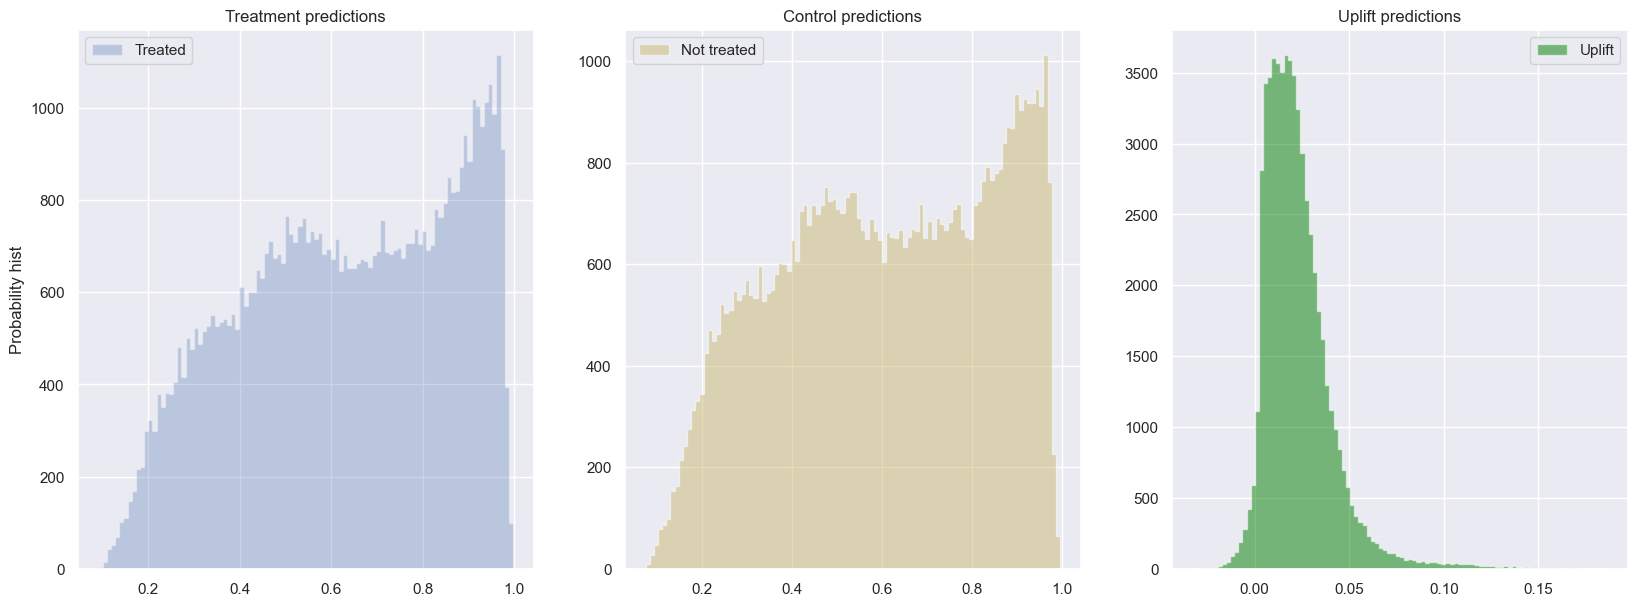

In [ ]:
sm_trmnt_preds = sm.trmnt_preds_
sm_ctrl_preds = sm.ctrl_preds_
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds)

In [187]:
uplift_table_sm = uplift_by_percentile(y_test, y_predict_sm, t_test, strategy='overall')
uplift_table_sm

,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift
percentile,,,,,
0-10,3024,2978,0.536045,0.424446,0.111599
10-20,3004,2998,0.531292,0.456971,0.074320
20-30,3004,2997,0.529960,0.510177,0.019783
30-40,3065,2936,0.571941,0.527248,0.044693
40-50,2991,3010,0.586760,0.560797,0.025963
50-60,3013,2988,0.636575,0.619813,0.016762
60-70,2986,3015,0.690891,0.670315,0.020576
70-80,3027,2974,0.742319,0.724277,0.018042
80-90,3014,2987,0.815196,0.792769,0.022427


## Two Models Approach -||- T-leaner 

Uses two separate models: one for the treated group, one for the control group.
Each learns P(y=1 | X, T=1) and P(y=1 | X, T=0) respectively, and uplift = difference.
It captures heterogeneity better than S-learner but can be biased if treatment/control groups are very unbalanced.

In [ ]:
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(
        iterations=500, learning_rate=0.03, depth=8,
        l2_leaf_reg=5,  
        colsample_bylevel=0.8,     
        loss_function='Logloss',
        eval_metric='Logloss',        
        random_state=42, verbose=0
    ),
    estimator_ctrl=CatBoostClassifier(
        iterations=500, learning_rate=0.03, depth=8,
        colsample_bylevel=0.8,             
        l2_leaf_reg=5,  
        loss_function='Logloss',
        eval_metric='Logloss',
        random_state=42, verbose=0
    )
)

tm.fit(
    X_train, y_train, t_train,
    estimator_trmnt_fit_params={'cat_features': cat_features},
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

y_pred_tm = tm.predict(X_test)  

In [190]:
qini_tm = round(qini_auc_score(y_test, y_pred_tm, t_test),4)
qini_tm
# plot_qini_curve(y_test, y_pred_tm, t_test)

0.0226

In [191]:
uplift_auc_tm = round(uplift_auc_score(y_test, y_pred_tm, t_test),4)
uplift_auc_tm
#plot_uplift_curve(y_test, y_predict_sm, t_test)

0.034

array([<Axes: title={'center': 'Treatment predictions'}, ylabel='Probability hist'>,
       <Axes: title={'center': 'Control predictions'}>,
       <Axes: title={'center': 'Uplift predictions'}>], dtype=object)

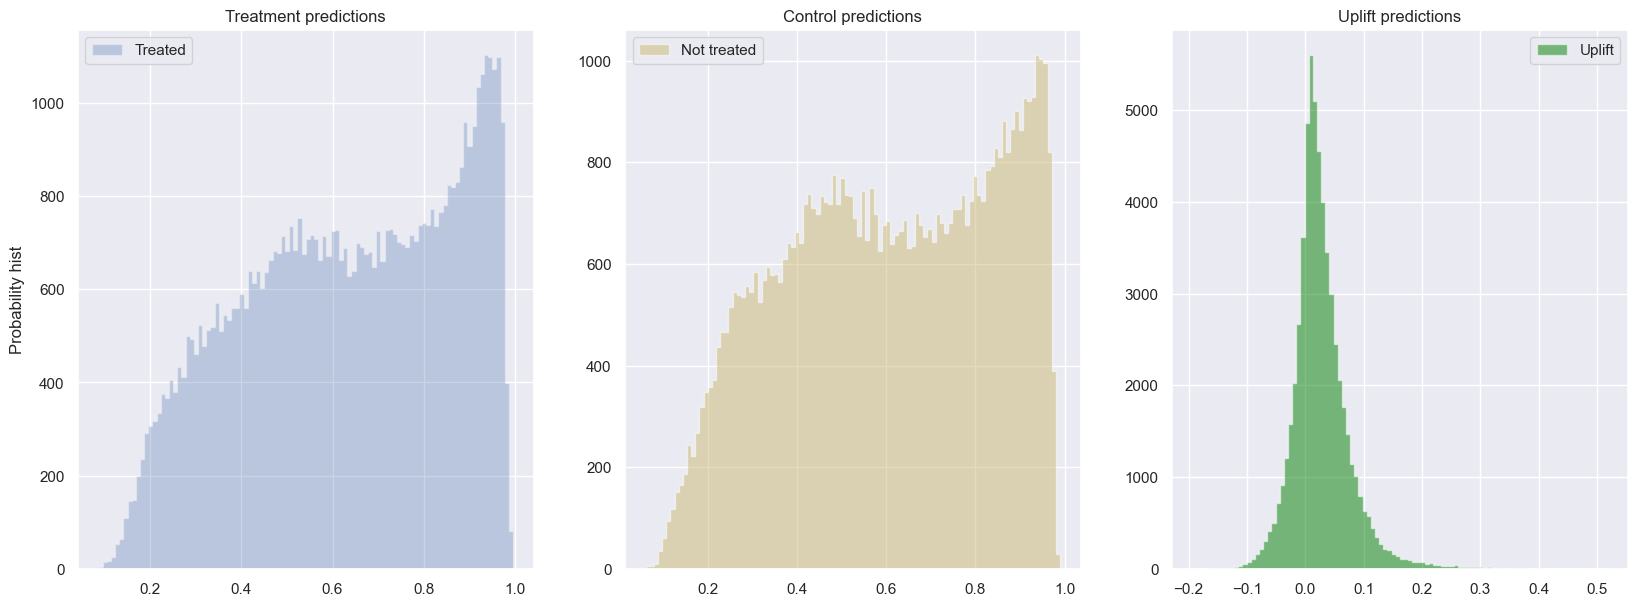

In [162]:
tm_trmnt_preds = tm.trmnt_preds_
tm_ctrl_preds = tm.ctrl_preds_
plot_uplift_preds(trmnt_preds=tm_trmnt_preds, ctrl_preds=tm_ctrl_preds)

In [192]:
uplift_table_tm = uplift_by_percentile(y_test, y_pred_tm, t_test, strategy='overall')
uplift_table_tm

,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift
percentile,,,,,
0-10,3102,2900,0.600580,0.442414,0.158166
10-20,3070,2932,0.572313,0.525580,0.046733
20-30,3005,2996,0.592013,0.548732,0.043282
30-40,3013,2988,0.631928,0.607095,0.024833
40-50,2978,3023,0.666891,0.650017,0.016874
50-60,3037,2964,0.728680,0.695682,0.032998
60-70,3000,3001,0.747667,0.726758,0.020909
70-80,2982,3019,0.705902,0.689964,0.015939
80-90,2996,3005,0.613818,0.604659,0.009160


## X-leaner

A meta-learner that improves T-learner by using “cross information”: it trains two models on treatment and control, then estimates pseudo-uplifts and re-fits models on them.
In practice, it’s better with unbalanced treatment proportions and can reduce variance.

to sum up: two models + additional regression on the difference

In [209]:
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [215]:
for c in cat_features:
    X_train[c] = LabelEncoder().fit_transform(X_train[c].astype(str))
    X_test[c] = LabelEncoder().fit_transform(X_test[c].astype(str))

# --- 2. Step 1: outcome models (T-learner stage) ---
model_treat = CatBoostRegressor(iterations=1000, depth=8, learning_rate=0.05, verbose=0, random_state=42)
model_ctrl  = CatBoostRegressor(iterations=1000, depth=8, learning_rate=0.05, verbose=0, random_state=42)

X_treat, y_treat = X_train[t_train == 1], y_train[t_train == 1]
X_ctrl,  y_ctrl  = X_train[t_train == 0], y_train[t_train == 0]

model_treat.fit(X_treat, y_treat, cat_features=cat_features)
model_ctrl.fit(X_ctrl, y_ctrl, cat_features=cat_features)

# --- 3. Step 2: pseudo-uplift labels ---
# For treated samples: what would have happened if control?
mu0_treat = model_ctrl.predict(X_treat)
D_treat = y_treat - mu0_treat  # pseudo effect for treated

# For control samples: what would have happened if treated?
mu1_ctrl = model_treat.predict(X_ctrl)
D_ctrl = mu1_ctrl - y_ctrl     # pseudo effect for control

# --- 4. Step 3: second-stage models (uplift regressors) ---
tau_treat = CatBoostRegressor(iterations=1000, depth=8, learning_rate=0.05, verbose=0, random_state=42)
tau_ctrl  = CatBoostRegressor(iterations=1000, depth=8, learning_rate=0.05, verbose=0, random_state=42)

tau_treat.fit(X_treat, D_treat, cat_features=cat_features)
tau_ctrl.fit(X_ctrl, D_ctrl, cat_features=cat_features)

# --- 5. Step 4: combine predictions using propensity scores ---
# Estimate propensity = P(T=1|X)
prop_model = CatBoostClassifier(iterations=500, depth=6, learning_rate=0.05, verbose=0, random_state=42)
prop_model.fit(X_train, t_train, cat_features=cat_features)
propensity = prop_model.predict_proba(X_test)[:, 1]

# --- 6. Step 5: combine X-learner predictions ---
tau1 = tau_treat.predict(X_test)   # uplift for treated
tau0 = tau_ctrl.predict(X_test)    # uplift for control
y_pred_x = propensity * tau0 + (1 - propensity) * tau1 

In [216]:
print("Qini AUC:", qini_auc_score(y_test, y_pred_x, t_test))
print("Uplift AUC:", uplift_auc_score(y_test, y_pred_x, t_test))

Qini AUC: 0.018073146624916388
Uplift AUC: 0.02733002545071294


In [244]:
uplift_table_x = uplift_by_percentile(
    y_true=y_test,
    uplift=y_pred_x,   # предсказания X-learner
    treatment=t_test,
    strategy='overall'   # можно 'by_group', если хочешь считать отдельно
)

uplift_table_x

,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift
percentile,,,,,
0-10,3044,2958,0.554205,0.439486,0.114719
10-20,3042,2960,0.584484,0.538851,0.045633
20-30,3101,2900,0.624637,0.578621,0.046017
30-40,3020,2981,0.637748,0.602147,0.035601
40-50,3021,2980,0.667991,0.625839,0.042152
50-60,3001,3000,0.673775,0.636667,0.037109
60-70,2983,3018,0.679182,0.661696,0.017486
70-80,2964,3037,0.676788,0.663484,0.013304
80-90,3008,2993,0.655585,0.656866,-0.001281


## Doubly Robust -||- DDR

Combines outcome models (P(y|X, T)) with a propensity model (P(T|X)) — hence “doubly robust”. Even if one of these two components is slightly wrong, the estimator stays unbiased. It’s more stable than plain T-learner, especially if treatment assignment isn’t perfectly random.

to sum up: uses the result model + the propensiity model

In [200]:
ddr = TwoModels(
    estimator_trmnt=CatBoostClassifier(
        iterations=500, learning_rate=0.03, depth=8,
        l2_leaf_reg=5,  
        colsample_bylevel=0.8,     
        loss_function='Logloss',
        eval_metric='Logloss',        
        random_state=42, verbose=0
    ),
    estimator_ctrl=CatBoostClassifier(
        iterations=500, learning_rate=0.03, depth=8,
        colsample_bylevel=0.8,             
        l2_leaf_reg=5,  
        loss_function='Logloss',
        eval_metric='Logloss',
        random_state=42, verbose=0 
    ),
       method='ddr_control'
)

ddr.fit(
    X_train, y_train, t_train,
    estimator_trmnt_fit_params={'cat_features': cat_features},
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

y_pred_ddr = ddr.predict(X_test)  

In [202]:
qini_ddr = round(qini_auc_score(y_test, y_pred_ddr, t_test),4)
qini_ddr

0.0221

In [201]:
uplift_auc_ddr = round(uplift_auc_score(y_test, y_pred_ddr, t_test),4)
uplift_auc_ddr

0.0331

array([<Axes: title={'center': 'Treatment predictions'}, ylabel='Probability hist'>,
       <Axes: title={'center': 'Control predictions'}>,
       <Axes: title={'center': 'Uplift predictions'}>], dtype=object)

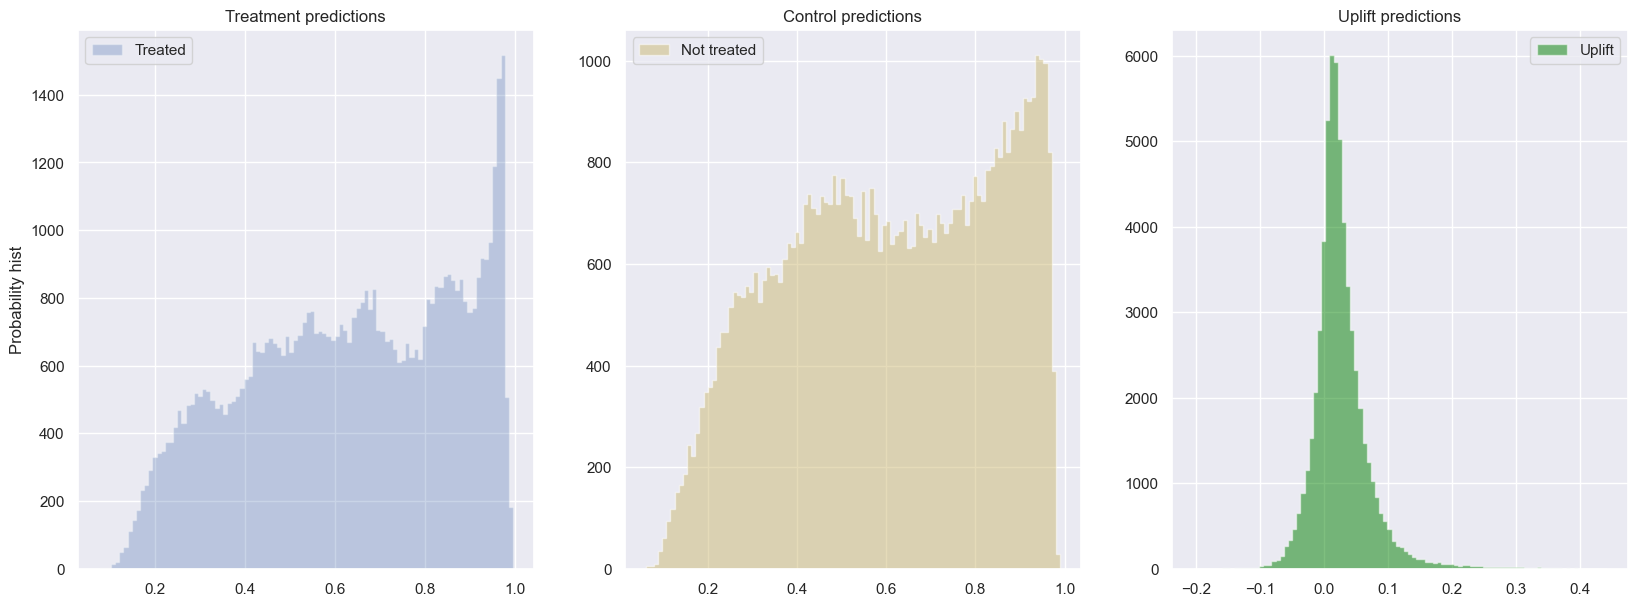

In [203]:
ddr_trmnt_preds = ddr.trmnt_preds_
ddr_ctrl_preds = ddr.ctrl_preds_
plot_uplift_preds(trmnt_preds=ddr_trmnt_preds, ctrl_preds=ddr_ctrl_preds)

In [204]:
uplift_table_ddr = uplift_by_percentile(y_test, y_pred_ddr, t_test, strategy='overall')
uplift_table_ddr

,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift
percentile,,,,,
0-10,3134,2868,0.604978,0.457462,0.147516
10-20,3014,2988,0.568016,0.501004,0.067012
20-30,2999,3002,0.604868,0.568288,0.036580
30-40,3048,2953,0.639436,0.615645,0.023791
40-50,3024,2977,0.706349,0.673161,0.033188
50-60,2995,3006,0.734224,0.725216,0.009007
60-70,3010,2991,0.735880,0.708793,0.027087
70-80,2917,3084,0.688721,0.683528,0.005193
80-90,2992,3009,0.590241,0.578930,0.011311


## Class Transformation

Transforms the problem into a binary classification task where the new label encodes both treatment and outcome.
Predictions for T=1 and T=0 are made separately and their difference gives the uplift.
It’s conceptually simple, fast, and works well with powerful classifiers — but it can be less interpretable.

In [316]:
ct = ClassTransformation(CatBoostClassifier(
        iterations=500, learning_rate=0.03, depth=8,
        l2_leaf_reg=5,  
        colsample_bylevel=0.8,     
        loss_function='Logloss',
        eval_metric='Logloss',        
        random_state=42, verbose=0))

ct = ct.fit(X_train, y_train, t_train, estimator_fit_params={'cat_features': cat_features})

y_pred_ct = ct.predict(X_test)

ct_score = uplift_at_k(y_true=y_test, uplift=y_pred_ct, treatment=t_test, strategy='by_group', k=0.3)

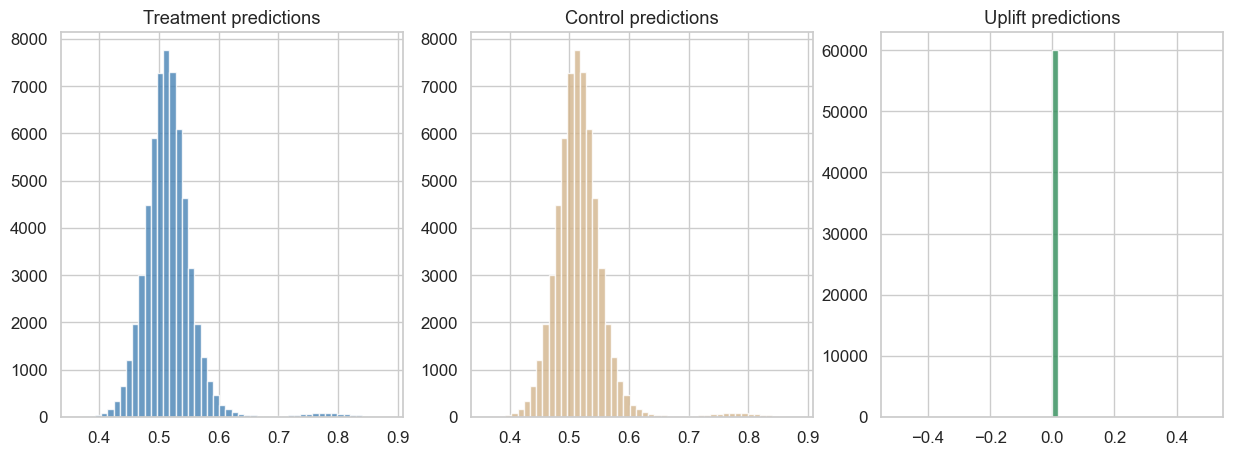

In [317]:
X_test_trmnt = X_test.copy()
X_test_ctrl  = X_test.copy()
X_test_trmnt['treatment'] = 1
X_test_ctrl['treatment']  = 0

ct_trmnt_preds = ct.estimator.predict_proba(X_test_trmnt)[:, 1]
ct_ctrl_preds  = ct.estimator.predict_proba(X_test_ctrl)[:, 1]

uplift_ct = ct_trmnt_preds - ct_ctrl_preds

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.hist(ct_trmnt_preds, bins=50, color='steelblue', alpha=0.8)
plt.title("Treatment predictions")

plt.subplot(1,3,2)
plt.hist(ct_ctrl_preds, bins=50, color='tan', alpha=0.8)
plt.title("Control predictions")

plt.subplot(1,3,3)
plt.hist(uplift_ct, bins=50, color='seagreen', alpha=0.8)
plt.title("Uplift predictions")
plt.show()

In [318]:
uplift_table_ct = uplift_by_percentile(y_test, y_pred_ct, t_test, strategy='overall')
uplift_table_ct

,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift
percentile,,,,,
0-10,3335,2667,0.649175,0.508811,0.140364
10-20,2991,3011,0.597793,0.538359,0.059434
20-30,3010,2991,0.612957,0.567369,0.045588
30-40,3014,2987,0.617120,0.583863,0.033257
40-50,2958,3043,0.628803,0.598751,0.030052
50-60,2967,3034,0.612066,0.600527,0.011539
60-70,2985,3016,0.630486,0.617042,0.013443
70-80,2972,3029,0.660834,0.628590,0.032244
80-90,2963,3038,0.663517,0.648124,0.015393


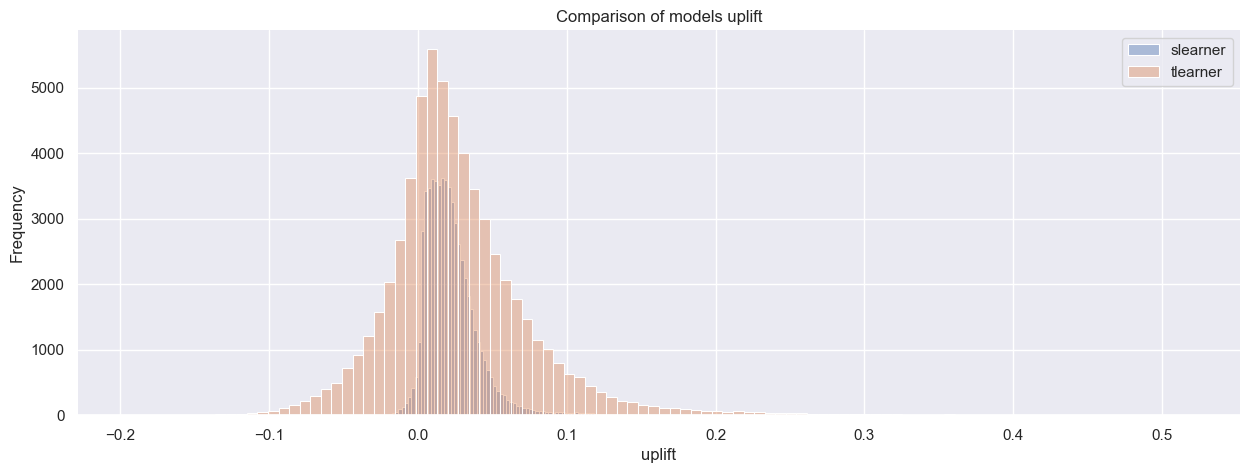

In [212]:
fig, ax = plt.subplots(figsize=(15,5))
sns.despine(left=True,right=True,top=True)

sns.histplot(y_predict_sm,bins=100,alpha=0.4,label='slearner')
sns.histplot(y_pred_tm,bins=100,alpha=0.4,label='tlearner')
ax.set_xlabel('uplift')
ax.set_ylabel('Frequency')
ax.set_title('Comparison of models uplift')
ax.legend()

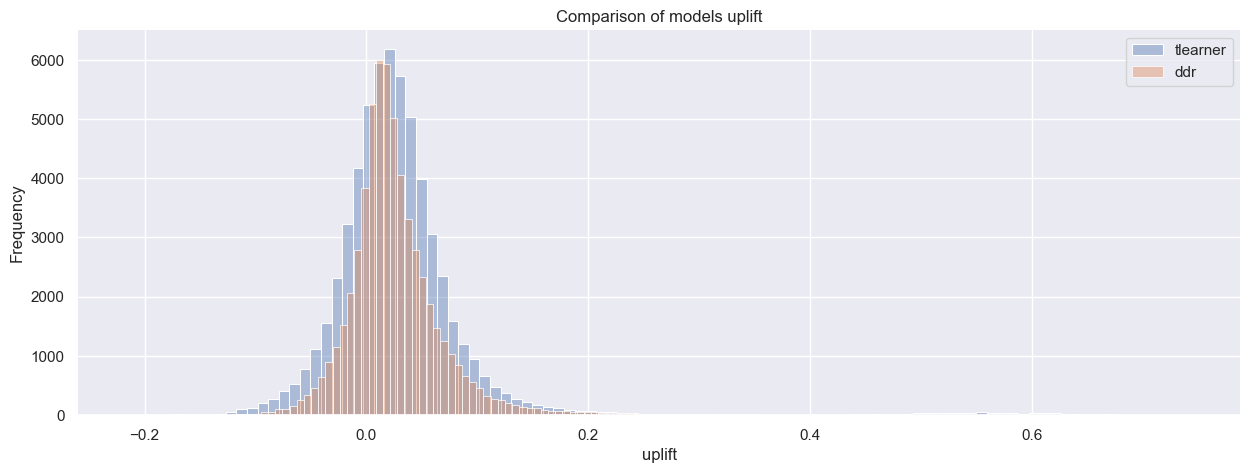

In [213]:
fig, ax = plt.subplots(figsize=(15,5))
sns.despine(left=True,right=True,top=True)

sns.histplot(y_pred_ct,bins=100,alpha=0.4,label='tlearner')
sns.histplot(y_pred_ddr,bins=100,alpha=0.4,label='ddr')
ax.set_xlabel('uplift')
ax.set_ylabel('Frequency')
ax.set_title('Comparison of models uplift')
ax.legend()

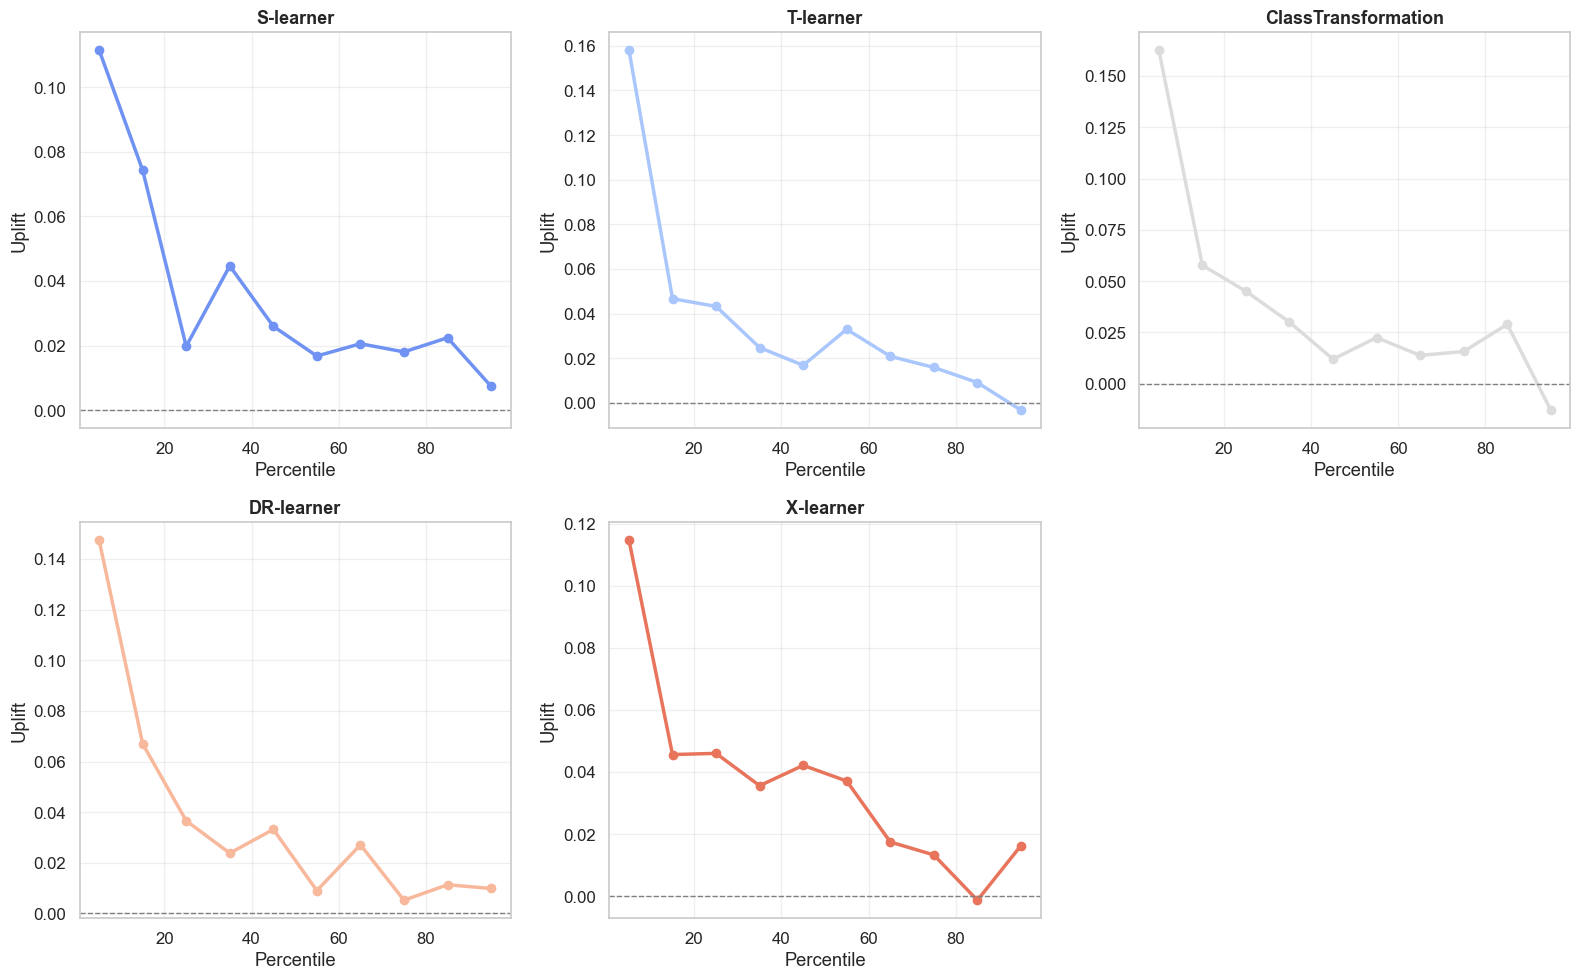

In [267]:
models = {
    "S-learner": y_predict_sm,
    "T-learner": y_pred_tm,
    "ClassTransformation": y_pred_ct,
    "DR-learner": y_pred_ddr,
    "X-learner": y_pred_x
}

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

palette = sns.color_palette("coolwarm", len(models))  # как у sklift

for i, (name, preds) in enumerate(models.items()):
    df = uplift_by_percentile(y_test, preds, t_test, strategy='overall').reset_index()
    df["percentile_mid"] = df["percentile"].str.split('-').apply(lambda x: (float(x[0])+float(x[1]))/2)
    
    axes[i].plot(
        df["percentile_mid"], df["uplift"],
        color=palette[i], marker='o', linewidth=2.5
    )
    axes[i].axhline(0, color='gray', lw=1, ls='--')
    axes[i].set_title(name, fontsize=13, fontweight='bold')
    axes[i].set_xlabel("Percentile")
    axes[i].set_ylabel("Uplift")
    axes[i].grid(True, alpha=0.3)

axes[-1].axis("off")

plt.tight_layout()
plt.show()


In [217]:
print("S-learner:", round(qini_auc_score(y_test, y_predict_sm, t_test),4))
print("T-learner:", round(qini_auc_score(y_test, y_pred_tm, t_test),4))
print("X-learner:", round(qini_auc_score(y_test, y_pred_x, t_test),4))
print("Class Transformation:", round(qini_auc_score(y_test, y_pred_ct, t_test),4))
print("Doubly Robust:", round(qini_auc_score(y_test, y_pred_ddr, t_test),4))

S-learner: 0.0166
T-learner: 0.0226
X-learner: 0.0181
Class Transformation: 0.0262
Doubly Robust: 0.0221


In [265]:
print("S-learner:", round(uplift_at_k(y_test, y_predict_sm, t_test, k=0.2, strategy='overall'),4))
print("T-learner:", round(uplift_at_k(y_test, y_pred_tm, t_test, k=0.2, strategy='overall'),4))
print("X-learner:", round(uplift_at_k(y_test, y_pred_x, t_test, k=0.2, strategy='overall'),4))
print("Class Transformation:", round(uplift_at_k(y_test, y_pred_ct, t_test, k=0.2, strategy='overall'),4))
print("Doubly Robust:", round(uplift_at_k(y_test, y_pred_ddr, t_test, k=0.2, strategy='overall'),4))

S-learner: 0.0928
T-learner: 0.1023
X-learner: 0.0802
Class Transformation: 0.1112
Doubly Robust: 0.107


- Class Transformation is currently winning in terms of Qini AUC, which means that it ranks customers most consistently in terms of uplift probability.
- Class Transformation is the best again, with uplift@20% ≈ 11% — that is, if you target the top 20% of customers, according to its forecasts, the effect of the campaign will be 11% higher than with a random selection.

# Apply for new users

Imagine that you need to make an upload for marketing so that they send messages, but only 20% of the base. We will use the Class Transformation model, which proved to be the best in train.

In [280]:
test=test.set_index('client_id')
test.head()

,age,date_diff_redeem_issue,first_issue_year,first_issue_month,first_issue_day,first_issue_hour,first_issue_date_weekday,first_redeem_year,first_redeem_month,first_redeem_day,...,december_sum,count_over_500,total_over_500,count_over_750,total_over_750,count_over_1000,total_over_1000,count_over_2000,total_over_2000,growth_90d
client_id,,,,,,,,,,,,,,,,,,,,,
000048b7a6,68.0,177,2018,12,15,13,5,2019,6,10,...,4005.00,8,29724.00,6,28475.00,6,28475.00,4,24917.00,21714.00
000073194a,60.0,184,2017,5,23,12,1,2017,11,24,...,1737.48,13,61370.92,12,60728.62,8,57335.49,7,55394.49,57328.96
00007c7133,67.0,588,2017,5,22,16,0,2018,12,31,...,27543.00,10,53658.72,10,53658.72,10,53658.72,9,52033.72,30644.72
00007f9014,45.0,542,2017,8,22,13,1,2019,2,15,...,5928.92,18,37077.79,16,35812.13,14,34087.25,6,23599.51,14076.79
0000a90cf7,45.0,49,2017,5,20,12,5,2017,7,8,...,56756.73,30,131647.80,25,128350.64,21,124926.53,12,112005.53,39818.28


In [ ]:
y_pred_ct_new= ct.predict(test)
test['uplift']=y_pred_ct

In [ ]:
test = test.sort_values(by='uplift', ascending=False)

In [288]:
top_20_cutoff = int(len(test) * 0.2)

In [ ]:
top_clients = test.head(top_20_cutoff)

In [292]:
top_clients

,age,date_diff_redeem_issue,first_issue_year,first_issue_month,first_issue_day,first_issue_hour,first_issue_date_weekday,first_redeem_year,first_redeem_month,first_redeem_day,...,count_over_500,total_over_500,count_over_750,total_over_750,count_over_1000,total_over_1000,count_over_2000,total_over_2000,growth_90d,uplift
client_id,,,,,,,,,,,,,,,,,,,,,
2a9e5c5f54,72.0,59,2019,1,24,12,3,2019,3,24,...,0,0.00,0,0.00,0,0.00,0,0.00,673.00,0.746305
7d3d59525f,76.0,63,2019,1,19,10,5,2019,3,23,...,0,0.00,0,0.00,0,0.00,0,0.00,606.00,0.736664
2d346672e2,65.0,48,2019,2,2,11,5,2019,3,23,...,4,5478.00,2,4000.00,2,4000.00,1,2968.00,6629.00,0.725851
9383ec9201,65.0,14,2019,3,8,9,4,2019,3,22,...,0,0.00,0,0.00,0,0.00,0,0.00,330.00,0.724862
e78bf83b6b,65.0,47,2019,2,4,10,0,2019,3,23,...,0,0.00,0,0.00,0,0.00,0,0.00,878.00,0.723846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c46bceef7c,38.0,37,2019,2,6,19,2,2019,3,16,...,13,72560.82,13,72560.82,13,72560.82,13,72560.82,72776.82,0.056645
a600e5d1a0,68.0,79,2017,10,27,17,4,2018,1,14,...,7,12734.00,4,10889.00,4,10889.00,2,8424.00,8879.00,0.056645
6d0b15aa3c,39.0,34,2019,1,13,17,6,2019,2,16,...,5,269163.49,5,269163.49,5,269163.49,5,269163.49,269176.44,0.056645


In [291]:
top_clients.index

Index(['2a9e5c5f54', '7d3d59525f', '2d346672e2', '9383ec9201', 'e78bf83b6b',
       'f71149b616', '72dde49e1a', 'cfc2ce6e37', '6e09f458c0', 'c3adc7b991',
       ...
       '7f5aba8daf', 'ef76699718', 'f395f8fe5c', '6896335ef4', 'a0bbfc503d',
       'c46bceef7c', 'a600e5d1a0', '6d0b15aa3c', '9d68eebf96', 'da033f294d'],
      dtype='object', name='client_id', length=40024)

## Simple profit estimates

In [ ]:
cost = 2
aov = 85    

def profit_at_k(y, uplift, t, k):
    n = len(y)
    top_n = int(k*n)
    thr = np.partition(uplift, -top_n)[-top_n]
    mask = uplift >= thr
    inc = (y[mask] & (t[mask]==1)).mean() - (y[mask] & (t[mask]==0)).mean() 
    return round((inc*aov-cost)*top_n,3)


In [356]:
profit_at_k(y_test, y_pred_ct, t_test, 0.2)

58871.0

In [357]:
profit_at_k(y_test, y_pred_ct, t_test, 0.3)

59364.0

In [358]:
profit_at_k(y_test, y_pred_ct, t_test, 0.5)

48533.0